In [3]:
import sys

sys.path.append ("..")
from LSTM模型 import keras_model  # 导入

In [4]:
#model = keras.models.load_model('best_model.hdf5')


In [5]:
data_path=r'M:\work\project_program\bishe\pyproject\RL_pid_control_critic_actor\强化学习+Lstm\稳压器水位压力控制\稳压器水位train数据.npy'
train_data=np.load(data_path,allow_pickle=True)
train_data=train_data.astype('float64')

NameError: name 'np' is not defined

In [ ]:
def get_str_time():
    s = '_'
    for i in time.localtime(time.time())[0:6]:
        s += str(i) + '_'
    return s


class SGTR_env():
    def __init__(self, model, set_point, train_datasets, mean, std):
        self.action_space = np.array([0] * 4)
        self.observation_space = np.array([0] * 8)
        self.mean = mean
        self.std = std
        self.response = []
        self.set_point = set_point
        self.train_datasets = train_datasets
        self.model = model
        self.state = self.train_datasets[random.randint(0, train_datasets.shape[0])]
        self.step_count = 0  # 步数计数

    def reset(self):
        self.step_count = 0
        # begin_index = [2500,6500,11000,14500]
        begin_index = range(1800, self.train_datasets.shape[0] - 3000, 100)
        state = self.train_datasets[random.sample(begin_index, 1)[0]]  # 10420]
        #  state = self.train_datasets[random.randint(0, self.train_datasets.shape[0]-1)]
        self.state = np.array(state)
        return np.array(state)

    def cal_origin_val(self, pos, now_val):
        """
        计算未归一化的值
        """
        val = now_val * self.std[pos] + self.mean[pos]
        return val

    def justice_down(self, next_state, step):
        """
        判断是否达到失败条件，deltaT<10或70分钟内未能实现一二回路压力平衡（小于1MP）
        """
        ori_deltaT = self.cal_origin_val(6, next_state[-1, 6])
        # ori_pressure = self.cal_origin_val(0,next_state[-1, 0])
        if ori_deltaT < 10:  # or (step>4200 and ori_pressure<1):
            return True

        else:
            return False

    def cal_reward(self, errors,states):
        level_k,level_k_1=states[-1][0],states[-2][0]
        press_k, press_k_1 = states[-1][1], states[-2][1]
        # 对达到设定值奖励
        b_1=2 if errors[0]==0.0 else 0
        b_2=2 if errors[1]==0.0 else 0
        reward_1=b_1+b_2

        # 对远离设定值惩罚
        c_1=-abs(errors[0])
        c_2=-abs(errors[1])
        reward_2=c_1+c_2

        # 对被控量剧烈变化惩罚
        d_1=-0.5*abs(level_k-level_k_1)
        d_2=-0.5*abs(press_k-press_k_1)
        reward_3=0  # d_1+d_2

        # 势函数，正态分布与RewardShaping进行比较
        # 正态分布
        mu, sigma = 0, 4
        f_1 = (1 / (math.sqrt(2 * math.pi) * sigma) * math.e ** (-(errors[0] - mu) ** 2 / (2 * sigma ** 2))) * 40
        f_2 = (1 / (math.sqrt(2 * math.pi) * sigma) * math.e ** (-(errors[1] - mu) ** 2 / (2 * sigma ** 2))) * 40
        # # RewardShaping
        # coef,rms=0.5,0.5
        # f_1 = coef * math.e **(-errors[0] ** 2 / (2 * rms))
        # f_2 = coef * math.e **(-errors[1] ** 2 / (2 * rms))
        reward_4= f_1+f_2

        reward=reward_1+reward_2+reward_3+reward_4

        return reward

    def step(self, action):
        self.step_count += 1
        self.state[-1, 4:] = action[:]
        # model(test_input, training=False)
        next_variable_state = np.array(self.model(np.array([self.state]), training=False))
        next_action = action
        zip_state_action = np.append(next_variable_state, next_action).reshape(1, -1)
        next_state = np.row_stack((self.state, zip_state_action))
        next_state = np.delete(next_state, 0, axis=0)
        self.state = next_state

        level_set_value = self.cal_changed_val(0, self.set_point[0])
        press_set_value = self.cal_changed_val(1, self.set_point[1])
        set_value = [level_set_value, press_set_value]

        now_level = next_state[-1, 0]
        now_press = next_state[-1, 1]
        error = [level_set_value - now_level, press_set_value - now_press]

        reward = self.cal_reward(error,next_state)
        done = False  # self.justice_down(next_state, self.step_count)

        return_state = next_state[-1].tolist()
        return_state.extend(error)
        return_state.extend(set_value)
        return np.array(return_state), reward, done, {}

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import random
import os,time

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import argparse
import os
import time


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import tensorlayer as tl

parser = argparse.ArgumentParser(description='Train or test neural net motor controller.')
parser.add_argument('--train', dest='train', action='store_true', default=True)
parser.add_argument('--test', dest='train', action='store_false')
args = parser.parse_args()

#####################  hyper parameters  ####################

ENV_NAME = 'Pendulum-v0'        # environment name
RANDOMSEED = 1                  # random seed

EP_MAX = 1000                   # total number of episodes for training
EP_LEN = 100                    # total number of steps for each episode
GAMMA = 0.9                     # reward discount
A_LR = 0.0001                   # learning rate for actor
C_LR = 0.0002                   # learning rate for critic
BATCH = 32                      # update batchsize
A_UPDATE_STEPS = 10     # actor update steps
C_UPDATE_STEPS = 10     # critic update steps
S_DIM, A_DIM = 4, 4     # state dimension, action dimension
EPS = 1e-8              # epsilon

# 注意：这里是PPO1和PPO2的相关的参数。
METHOD = [
    dict(name='kl_pen', kl_target=0.01, lam=0.5),   # KL penalty  PPO1
    dict(name='clip', epsilon=0.2),                 # Clipped surrogate objective, find this is better  PPO2
][1]                                                # choose the method for optimization
#METHOD=METHOD[1]
###############################  PPO  ####################################


class PPO(object):
    '''
    PPO 类
    '''

    def __init__(self):

        # 构建critic网络：
        # 输入state，输出V值
        tfs = tl.layers.Input([None, S_DIM], tf.float32, 'state')
        l1 = tl.layers.Dense(100, tf.nn.relu)(tfs)
        v = tl.layers.Dense(1)(l1)
        self.critic = tl.models.Model(tfs, v)
        self.critic.train()

        # 构建actor网络：
        # actor有两个：actor 和 actor_old， actor_old的主要功能是记录行为策略的版本。
        # 输入是state，输出是描述动作分布的mu和sigma
        self.actor = self._build_anet('pi', trainable=True)
        self.actor_old = self._build_anet('oldpi', trainable=False)
        self.actor_opt = tf.optimizers.Adam(A_LR)
        self.critic_opt = tf.optimizers.Adam(C_LR)

    def a_train(self, tfs, tfa, tfadv):
        '''
        更新策略网络(policy network)
        '''
        # 输入是s，a，td-error。这个和AC是类似的。
        tfs = np.array(tfs, np.float32)         #state
        tfa = np.array(tfa, np.float32)         #action
        tfadv = np.array(tfadv, np.float32)     #td-error


        with tf.GradientTape() as tape:

            # 我们需要从两个不同网络，构建两个正态分布pi，oldpi。
            mu, sigma = self.actor(tfs)
            pi = random.normalvariate(mu, sigma)

            mu_old, sigma_old = self.actor_old(tfs)
            oldpi = random.normalvariate(mu_old, sigma_old)

            # ratio = tf.exp(pi.log_prob(self.tfa) - oldpi.log_prob(self.tfa))
            # 在新旧两个分布下，同样输出a的概率的比值
            # 除以(oldpi.prob(tfa) + EPS)，其实就是做了import-sampling。怎么解释这里好呢
            # 本来我们是可以直接用pi.prob(tfa)去跟新的，但为了能够更新多次，我们需要除以(oldpi.prob(tfa) + EPS)。
            # 在AC或者PG，我们是以1,0作为更新目标，缩小动作概率到1or0的差距
            # 而PPO可以想作是，以oldpi.prob(tfa)出发，不断远离（增大or缩小）的过程。
            ratio = pi.prob(tfa) / (oldpi.prob(tfa) + EPS)
            # 这个的意义和带参数更新是一样的。
            surr = ratio * tfadv

            # 我们还不能让两个分布差异太大。
            # PPO1
            if METHOD['name'] == 'kl_pen':
                tflam = METHOD['lam']
                kl = tfp.distributions.kl_divergence(oldpi, pi)
                kl_mean = tf.reduce_mean(kl)
                aloss = -(tf.reduce_mean(surr - tflam * kl))
            # PPO2：
            # 很直接，就是直接进行截断。
            else:  # clipping method, find this is better
                aloss = -tf.reduce_mean(
                    tf.minimum(ratio * tfadv,  #surr
                               tf.clip_by_value(ratio, 1. - METHOD['epsilon'], 1. + METHOD['epsilon']) * tfadv)
                )
        a_gard = tape.gradient(aloss, self.actor.trainable_weights)

        self.actor_opt.apply_gradients(zip(a_gard, self.actor.trainable_weights))

        if METHOD['name'] == 'kl_pen':
            return kl_mean

    def update_old_pi(self):
        '''
        更新actor_old参数。
        '''
        for p, oldp in zip(self.actor.trainable_weights, self.actor_old.trainable_weights):
            oldp.assign(p)

    def c_train(self, tfdc_r, s):
        '''
        更新Critic网络
        '''
        tfdc_r = np.array(tfdc_r, dtype=np.float32) #tfdc_r可以理解为PG中就是G，通过回溯计算。只不过这PPO用TD而已。

        with tf.GradientTape() as tape:
            v = self.critic(s)
            advantage = tfdc_r - v                  # 就是我们说的td-error
            closs = tf.reduce_mean(tf.square(advantage))

        grad = tape.gradient(closs, self.critic.trainable_weights)
        self.critic_opt.apply_gradients(zip(grad, self.critic.trainable_weights))

    def cal_adv(self, tfs, tfdc_r):
        '''
        计算advantage，也就是td-error
        '''
        tfdc_r = np.array(tfdc_r, dtype=np.float32)
        advantage = tfdc_r - self.critic(tfs)           # advantage = r - gamma * V(s_)
        return advantage.numpy()

    def update(self, s, a, r):
        '''
        Update parameter with the constraint of KL divergent
        :param s: state
        :param a: act
        :param r: reward
        :return: None
        '''
        s, a, r = s.astype(np.float32), a.astype(np.float32), r.astype(np.float32)

        self.update_old_pi()
        adv = self.cal_adv(s, r)
        # adv = (adv - adv.mean())/(adv.std()+1e-6)  # sometimes helpful

        # update actor
        #### PPO1比较复杂:
        # 动态调整参数 adaptive KL penalty
        if METHOD['name'] == 'kl_pen':
            for _ in range(A_UPDATE_STEPS):
                kl = self.a_train(s, a, adv)
                if kl > 4 * METHOD['kl_target']:  # this in in google's paper
                    break
            if kl < METHOD['kl_target'] / 1.5:  # adaptive lambda, this is in OpenAI's paper
                METHOD['lam'] /= 2
            elif kl > METHOD['kl_target'] * 1.5:
                METHOD['lam'] *= 2
            METHOD['lam'] = np.clip(
                METHOD['lam'], 1e-4, 10
            )  # sometimes explode, this clipping is MorvanZhou's solution

        #### PPO2比较简单，直接就进行a_train更新:
        # clipping method, find this is better (OpenAI's paper)
        else:
            for _ in range(A_UPDATE_STEPS):
                self.a_train(s, a, adv)

        # 更新 critic
        for _ in range(C_UPDATE_STEPS):
            self.c_train(r, s)

    def _build_anet(self, name, trainable):
        '''
        Build policy network
        :param name: name
        :param trainable: trainable flag
        :return: policy network
        '''
        # 连续动作型问题，输出mu和sigma。
        tfs = tl.layers.Input([None, S_DIM], tf.float32, name + '_state')
        l1 = tl.layers.Dense(100, tf.nn.relu, name=name + '_l1')(tfs)

        a = tl.layers.Dense(A_DIM, tf.nn.tanh, name=name + '_a')(l1)
        mu = tl.layers.Lambda(lambda x: x * 2, name=name + '_lambda')(a)

        sigma = tl.layers.Dense(A_DIM, tf.nn.softplus, name=name + '_sigma')(l1)

        model = tl.models.Model(tfs, [mu, sigma], name)

        if trainable:
            model.train()
        else:
            model.eval()
        return model

    def choose_action(self, s):
        '''
        Choose action
        :param s: state
        :return: clipped act
        '''
        s = s[np.newaxis, :].astype(np.float32)
        mu, sigma = self.actor(s)                   # 通过actor计算出分布的mu和sigma
        pi = tfp.distributions.Normal(mu, sigma)    # 用mu和sigma构建正态分布
        a = tf.squeeze(pi.sample(1), axis=0)[0]     # 根据概率分布随机出动作
        return np.clip(a, -2, 2)                    # 最后sample动作，并进行裁剪。

    def get_v(self, s):
        '''
        计算value值。
        '''
        s = s.astype(np.float32)
        if s.ndim < 2: s = s[np.newaxis, :]  # 要和输入的形状对应。
        return self.critic(s)[0, 0]

    def save_ckpt(self):
        """
        save trained weights
        :return: None
        """
        if not os.path.exists('model'):
            os.makedirs('model')
        tl.files.save_weights_to_hdf5('model/ppo_actor.hdf5', self.actor)
        tl.files.save_weights_to_hdf5('model/ppo_actor_old.hdf5', self.actor_old)
        tl.files.save_weights_to_hdf5('model/ppo_critic.hdf5', self.critic)

    def load_ckpt(self):
        """
        load trained weights
        :return: None
        """
        tl.files.load_hdf5_to_weights_in_order('model/ppo_actor.hdf5', self.actor)
        tl.files.load_hdf5_to_weights_in_order('model/ppo_actor_old.hdf5', self.actor_old)
        tl.files.load_hdf5_to_weights_in_order('model/ppo_critic.hdf5', self.critic)


if __name__ == '__main__':

    env = SGTR_env()

    # reproducible
    np.random.seed(RANDOMSEED)
    tf.random.set_seed(RANDOMSEED)

    ppo = PPO()


    all_ep_r = []

    # 更新流程：
    for ep in range(EP_MAX):
        s = env.reset()
        buffer_s, buffer_a, buffer_r = [], [], []
        ep_r = 0
        t0 = time.time()
        for t in range(EP_LEN):  # in one episode
            # env.render()
            a = ppo.choose_action(s)
            s_, r, done, _ = env.step(a)
            buffer_s.append(s)
            buffer_a.append(a)
            buffer_r.append((r + 8) / 8)    # 对奖励进行归一化。有时候会挺有用的。所以我们说说，奖励是个主观的东西。
            s = s_
            ep_r += r

            # # N步更新的方法，每BATCH步了就可以进行一次更新
            if (t + 1) % BATCH == 0 or t == EP_LEN - 1:
                v_s_ = ppo.get_v(s_)        # 计算n步中最后一个state的v_s_

                # 和PG一样，向后回溯计算。
                discounted_r = []
                for r in buffer_r[::-1]:
                    v_s_ = r + GAMMA * v_s_
                    discounted_r.append(v_s_)
                discounted_r.reverse()

                # 所以这里的br并不是每个状态的reward，而是通过回溯计算的V值
                bs, ba, br = np.vstack(buffer_s), np.vstack(buffer_a), np.array(discounted_r)[:, np.newaxis]
                buffer_s, buffer_a, buffer_r = [], [], []
                ppo.update(bs, ba, br)


        if ep == 0:
            all_ep_r.append(ep_r)
        else:
            all_ep_r.append(all_ep_r[-1] * 0.9 + ep_r * 0.1)
        print(
            'Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
                ep, EP_MAX, ep_r,
                time.time() - t0
            )
        )

        #画图
        plt.ion()
        plt.cla()
        plt.title('PPO')
        plt.plot(np.arange(len(all_ep_r)), all_ep_r)
        plt.ylim(-2000, 0)
        plt.xlabel('Episode')
        plt.ylabel('Moving averaged episode reward')
        plt.show()
        plt.pause(0.1)
    ppo.save_ckpt()
    plt.ioff()
    plt.show()

    # # test
    # ppo.load_ckpt()
    # while True:
    #     s = env.reset()
    #     for i in range(EP_LEN):
    #         env.render()
    #         s, r, done, _ = env.step(ppo.choose_action(s))
    #         if done:
    #             break

usage: ipykernel_launcher.py [-h] [--train] [--test]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\lenovo\AppData\Roaming\jupyter\runtime\kernel-ca9c6e90-ad03-49c1-b418-a41f1a632575.json


SystemExit: 2

M:\work\softfiles\Anaconda3\envs\tensorflow_gpu_version\lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
import sys

sys.path.append("..")
from tensorflow import keras
import numpy as np
import random

import math

import os
import time

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

import tensorlayer as tl

model = keras.models.load_model('best_model.hdf5')

data_path = r'M:\work\project_program\bishe\pyproject\RL_pid_control_critic_actor\强化学习+Lstm\稳压器水位压力控制\train_datasets' \
            r'.npy '
train_data = np.load(data_path, allow_pickle=True)
mean, std = train_data[1].astype('float64'), train_data[2].astype('float64')
train_data = train_data[0].astype('float64')
pass

def get_str_time():
    s = '_'
    for i in time.localtime(time.time())[0:6]:
        s += str(i) + '_'
    return s


class SGTR_env():
    def __init__(self, model, set_point, train_datasets, mean, std):
        self.action_space = np.array([0] * 4)
        self.observation_space = np.array([0] * 8)
        self.mean = mean
        self.std = std
        self.response = []
        self.set_point = set_point
        self.train_datasets = train_datasets
        self.model = model
        self.state = self.train_datasets[1500]
        self.step_count = 0  # 步数计数

    def reset(self):
        self.step_count = 0
        # begin_index = [2500,6500,11000,14500]
        begin_index = 1500 # range(1800, self.train_datasets.shape[0] - 3000, 100)
        state = self.train_datasets[begin_index] # random.sample(begin_index, 1)[0]]  # 10420]
        #  state = self.train_datasets[random.randint(0, self.train_datasets.shape[0]-1)]
        self.state = np.array(state)
        return np.array(state)

    def cal_origin_val(self, pos, now_val):
        """
        计算未归一化的值
        """
        val = now_val * self.std[pos] + self.mean[pos]
        return val

    def cal_changed_val(self, pos, now_val):
        """
        计算归一化后的值
        """
        val = (now_val - self.mean[pos]) / self.std[pos]
        return val

    def justice_down(self, next_state, step):
        """
        判断是否达到失败条件，deltaT<10或70分钟内未能实现一二回路压力平衡（小于1MP）
        """
        ori_deltaT = self.cal_origin_val(6, next_state[-1, 6])
        # ori_pressure = self.cal_origin_val(0,next_state[-1, 0])
        if ori_deltaT < 10:  # or (step>4200 and ori_pressure<1):
            return True

        else:
            return False

    def cal_reward(self, errors,states):
        level_k,level_k_1=states[-1][0],states[-2][0]
        press_k, press_k_1 = states[-1][1], states[-2][1]
        # 对达到设定值奖励
        b_1=2 if errors[0]==0.0 else 0
        b_2=2 if errors[1]==0.0 else 0
        reward_1=b_1+b_2

        # 对远离设定值惩罚
        c_1=-abs(errors[0])
        c_2=-abs(errors[1])
        reward_2=c_1+c_2

        # 对被控量剧烈变化惩罚
        d_1=-0.5*abs(level_k-level_k_1)
        d_2=-0.5*abs(press_k-press_k_1)
        reward_3=0  # d_1+d_2

        # 势函数，正态分布与RewardShaping进行比较
        # 正态分布
        mu, sigma = 0, 4
        f_1 = (1 / (math.sqrt(2 * math.pi) * sigma) * math.e ** (-(errors[0] - mu) ** 2 / (2 * sigma ** 2))) * 40
        f_2 = (1 / (math.sqrt(2 * math.pi) * sigma) * math.e ** (-(errors[1] - mu) ** 2 / (2 * sigma ** 2))) * 40
        # # RewardShaping
        # coef,rms=0.5,0.5
        # f_1 = coef * math.e **(-errors[0] ** 2 / (2 * rms))
        # f_2 = coef * math.e **(-errors[1] ** 2 / (2 * rms))
        reward_4= f_1+f_2

        reward=reward_1+reward_2+reward_3+reward_4

        return reward

    def step(self, action):
        self.step_count += 1
        self.state[-1, 4:] = action[:]
        # model(test_input, training=False)
        next_variable_state = np.array(self.model(np.array([self.state]), training=False))
        next_action = action
        zip_state_action = np.append(next_variable_state, next_action).reshape(1, -1)
        next_state = np.row_stack((self.state, zip_state_action))
        next_state = np.delete(next_state, 0, axis=0)
        self.state = next_state

        # level_set_value = self.cal_changed_val(0, self.set_point[0])
        # press_set_value = self.cal_changed_val(1, self.set_point[1])
        set_value = [self.set_point[0], self.set_point[1]]

        now_level = next_state[-1, 0]
        now_press = next_state[-1, 1]
        error = [set_value[0] - now_level, set_value[1] - now_press]

        reward = self.cal_reward(error,next_state)
        done = False  # self.justice_down(next_state, self.step_count)

        # return_state = next_state[-1].tolist()
        # return_state.extend(error)
        # return_state.extend(set_value)
        return np.array(self.state).reshape(1,80), reward, done, {}


#####################  hyper parameters  ####################
RANDOMSEED = 1  # random seed

EP_MAX = 1000  # total number of episodes for training
EP_LEN = 100  # total number of steps for each episode
GAMMA = 0.9  # reward discount
A_LR = 0.0001  # learning rate for actor
C_LR = 0.0002  # learning rate for critic
BATCH = 32  # update batchsize
A_UPDATE_STEPS = 10  # actor update steps
C_UPDATE_STEPS = 10  # critic update steps
S_DIM, A_DIM = 80, 4  # state dimension, action dimension
EPS = 1e-8  # epsilon

# 注意：这里是PPO1和PPO2的相关的参数。
METHOD = [
    dict(name='kl_pen', kl_target=0.01, lam=0.5),  # KL penalty  PPO1
    dict(name='clip', epsilon=0.2),  # Clipped surrogate objective, find this is better  PPO2
][1]  # choose the method for optimization


# METHOD=METHOD[1]
###############################  PPO  ####################################

class PPO(object):
    '''
    PPO 类
    '''

    def __init__(self):

        # 构建critic网络：
        # 输入state，输出V值
        tfs = tl.layers.Input([None, S_DIM], tf.float32, 'state')
        l1 = tl.layers.Dense(100, tf.nn.relu)(tfs)
        v = tl.layers.Dense(1)(l1)
        self.critic = tl.models.Model(tfs, v)
        self.critic.train()

        # 构建actor网络：
        # actor有两个actor 和 actor_old， actor_old的主要功能是记录行为策略的版本。
        # 输入时state，输出是描述动作分布的mu和sigma
        self.actor = self._build_anet('pi', trainable=True)
        self.actor_old = self._build_anet('oldpi', trainable=False)
        self.actor_opt = tf.optimizers.Adam(A_LR)
        self.critic_opt = tf.optimizers.Adam(C_LR)

    def a_train(self, tfs, tfa, tfadv):
        '''
        更新策略网络(policy network)
        '''
        # 输入时s，a，td-error。这个和AC是类似的。
        tfs = np.array(tfs, np.float32)         #state
        tfa = np.array(tfa, np.float32)         #action
        tfadv = np.array(tfadv, np.float32)     #td-error


        with tf.GradientTape() as tape:

            # 【敲黑板】这里是重点！！！！
            # 我们需要从两个不同网络，构建两个正态分布pi，oldpi。
            mu, sigma = self.actor(tfs)
            pi = tfp.distributions.Normal(mu, sigma)

            mu_old, sigma_old = self.actor_old(tfs)
            oldpi = tfp.distributions.Normal(mu_old, sigma_old)

            # ratio = tf.exp(pi.log_prob(self.tfa) - oldpi.log_prob(self.tfa))
            # 在新旧两个分布下，同样输出a的概率的比值
            # 除以(oldpi.prob(tfa) + EPS)，其实就是做了import-sampling。怎么解释这里好呢
            # 本来我们是可以直接用pi.prob(tfa)去跟新的，但为了能够更新多次，我们需要除以(oldpi.prob(tfa) + EPS)。
            # 在AC或者PG，我们是以1,0作为更新目标，缩小动作概率到1or0的差距
            # 而PPO可以想作是，以oldpi.prob(tfa)出发，不断远离（增大or缩小）的过程。
            ratio = pi.prob(tfa) / (oldpi.prob(tfa) + EPS)
            # 这个的意义和带参数更新是一样的。
            surr = ratio * tfadv

            # 我们还不能让两个分布差异太大。
            # PPO1
            if METHOD['name'] == 'kl_pen':
                tflam = METHOD['lam']
                kl = tfp.distributions.kl_divergence(oldpi, pi)
                kl_mean = tf.reduce_mean(kl)
                aloss = -(tf.reduce_mean(surr - tflam * kl))
            # PPO2：
            # 很直接，就是直接进行截断。
            else:  # clipping method, find this is better
                aloss = -tf.reduce_mean(
                    tf.minimum(ratio * tfadv,  #surr
                               tf.clip_by_value(ratio, 1. - METHOD['epsilon'], 1. + METHOD['epsilon']) * tfadv)
                )
        a_gard = tape.gradient(aloss, self.actor.trainable_weights)

        self.actor_opt.apply_gradients(zip(a_gard, self.actor.trainable_weights))

        if METHOD['name'] == 'kl_pen':
            return kl_mean

    def update_old_pi(self):
        '''
        更新actor_old参数。
        '''
        for p, oldp in zip(self.actor.trainable_weights, self.actor_old.trainable_weights):
            oldp.assign(p)

    def c_train(self, tfdc_r, s):
        '''
        更新Critic网络
        '''
        tfdc_r = np.array(tfdc_r, dtype=np.float32) #tfdc_r可以理解为PG中就是G，通过回溯计算。只不过这PPO用TD而已。

        with tf.GradientTape() as tape:
            v = self.critic(s)
            advantage = tfdc_r - v                  # 就是我们说的td-error
            closs = tf.reduce_mean(tf.square(advantage))

        grad = tape.gradient(closs, self.critic.trainable_weights)
        self.critic_opt.apply_gradients(zip(grad, self.critic.trainable_weights))

    def cal_adv(self, tfs, tfdc_r):
        '''
        计算advantage，也就是td-error
        '''
        tfdc_r = np.array(tfdc_r, dtype=np.float32)
        advantage = tfdc_r - self.critic(tfs)           # advantage = r - gamma * V(s_)
        return advantage.numpy()

    def update(self, s, a, r):
        '''
        Update parameter with the constraint of KL divergent
        :param s: state
        :param a: act
        :param r: reward
        :return: None
        '''
        s, a, r = s.astype(np.float32), a.astype(np.float32), r.astype(np.float32)

        self.update_old_pi()
        adv = self.cal_adv(s, r)
        # adv = (adv - adv.mean())/(adv.std()+1e-6)  # sometimes helpful

        # update actor
        #### PPO1比较复杂:
        # 动态调整参数 adaptive KL penalty
        if METHOD['name'] == 'kl_pen':
            for _ in range(A_UPDATE_STEPS):
                kl = self.a_train(s, a, adv)
                if kl > 4 * METHOD['kl_target']:  # this in in google's paper
                    break
            if kl < METHOD['kl_target'] / 1.5:  # adaptive lambda, this is in OpenAI's paper
                METHOD['lam'] /= 2
            elif kl > METHOD['kl_target'] * 1.5:
                METHOD['lam'] *= 2
            METHOD['lam'] = np.clip(
                METHOD['lam'], 1e-4, 10
            )  # sometimes explode, this clipping is MorvanZhou's solution

        #### PPO2比较简单，直接就进行a_train更新:
        # clipping method, find this is better (OpenAI's paper)
        else:
            for _ in range(A_UPDATE_STEPS):
                self.a_train(s, a, adv)

        # 更新 critic
        for _ in range(C_UPDATE_STEPS):
            self.c_train(r, s)

    def _build_anet(self, name, trainable):
        '''
        Build policy network
        :param name: name
        :param trainable: trainable flag
        :return: policy network
        '''
        # 连续动作型问题，输出mu和sigma。
        tfs = tl.layers.Input([None, S_DIM], tf.float32, name + '_state')
        l1 = tl.layers.Dense(100, tf.nn.relu, name=name + '_l1')(tfs)

        a = tl.layers.Dense(A_DIM, tf.nn.tanh, name=name + '_a')(l1)
        mu = tl.layers.Lambda(lambda x: x * 2, name=name + '_lambda')(a)

        sigma = tl.layers.Dense(A_DIM, tf.nn.softplus, name=name + '_sigma')(l1)

        model = tl.models.Model(tfs, [mu, sigma], name)

        if trainable:
            model.train()
        else:
            model.eval()
        return model

    def choose_action(self, s):
        '''
        Choose action
        :param s: state
        :return: clipped act
        '''
        s = s[np.newaxis, :].astype(np.float32)
        mu, sigma = self.actor(s)                   # 通过actor计算出分布的mu和sigma
        pi = tfp.distributions.Normal(mu, sigma)    # 用mu和sigma构建正态分布
        a = tf.squeeze(pi.sample(1), axis=0)[0]     # 根据概率分布随机出动作
        return np.clip(a, -2, 2)                    # 最后sample动作，并进行裁剪。

    def get_v(self, s):
        '''
        计算value值。
        '''
        s = s.astype(np.float32)
        if s.ndim < 2: s = s[np.newaxis, :]  # 要和输入的形状对应。
        return self.critic(s)[0, 0]

    def save_ckpt(self):
        """
        save trained weights
        :return: None
        """
        if not os.path.exists('model'):
            os.makedirs('model')
        tl.files.save_weights_to_hdf5('model/ppo_actor.hdf5', self.actor)
        tl.files.save_weights_to_hdf5('model/ppo_actor_old.hdf5', self.actor_old)
        tl.files.save_weights_to_hdf5('model/ppo_critic.hdf5', self.critic)

    def load_ckpt(self):
        """
        load trained weights
        :return: None
        """
        tl.files.load_hdf5_to_weights_in_order('model/ppo_actor.hdf5', self.actor)
        tl.files.load_hdf5_to_weights_in_order('model/ppo_actor_old.hdf5', self.actor_old)
        tl.files.load_hdf5_to_weights_in_order('model/ppo_critic.hdf5', self.critic)





def train():
    env = SGTR_env(model, [-0.46, -0.33], train_data, mean, std)

    # reproducible
    np.random.seed(RANDOMSEED)
    tf.random.set_seed(RANDOMSEED)

    ppo = PPO()

    all_ep_r = []

    # 更新流程：
    for ep in range(EP_MAX):
        s = env.reset()
        s=s.reshape(1,80)
        buffer_s, buffer_a, buffer_r = [], [], []
        ep_r = 0
        t0 = time.time()
        for t in range(EP_LEN):  # in one episode
            # env.render()
            a = ppo.choose_action(s)
            s_, r, done, _ = env.step(a)
            buffer_s.append(s)
            buffer_a.append(a)
            buffer_r.append((r + 8) / 8)  # 对奖励进行归一化。有时候会挺有用的。所以我们说说，奖励是个主观的东西。
            s = s_
            ep_r += r

            # # N步更新的方法，每BATCH步了就可以进行一次更新
            if (t + 1) % BATCH == 0 or t == EP_LEN - 1:
                v_s_ = ppo.get_v(s_)  # 计算n步中最后一个state的v_s_

                # 和PG一样，向后回溯计算。
                discounted_r = []
                for r in buffer_r[::-1]:
                    v_s_ = r + GAMMA * v_s_
                    discounted_r.append(v_s_)
                discounted_r.reverse()

                # 所以这里的br并不是每个状态的reward，而是通过回溯计算的V值
                bs, ba, br = np.vstack(buffer_s), np.vstack(buffer_a), np.array(discounted_r)[:, np.newaxis]
                buffer_s, buffer_a, buffer_r = [], [], []
                ppo.update(bs, ba, br)

        if ep == 0:
            all_ep_r.append(ep_r)
        else:
            all_ep_r.append(all_ep_r[-1] * 0.9 + ep_r * 0.1)
        print(
            'Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
                ep, EP_MAX, ep_r,
                time.time() - t0
            )
        )

    ppo.save_ckpt()

from tqdm import  tqdm


env = SGTR_env(model, [-0.1, -0.2], train_data, mean, std)

# reproducible
np.random.seed(RANDOMSEED)
tf.random.set_seed(RANDOMSEED)

ppo = PPO()

step_r = []
sum_r=[0]

ppo.load_ckpt()
s = env.reset().reshape(1,80)
state=[s]
for i in tqdm(range(1000)):
    # if i ==200:
    #     env.set_point=[-0.36,-0.23]
    s_, r, done, _ = env.step(ppo.choose_action(s))
    step_r.append(r)
    sum_r.append(r+sum_r[-1])
    state.append(s_)
    s=s_
    if done:
        break


[TL] Input  state: [None, 80]
[TL] Dense  dense_1: 100 relu
[TL] Dense  dense_2: 1 No Activation
[TL] Input  pi_state: [None, 80]
[TL] Dense  pi_l1: 100 relu
[TL] Dense  pi_a: 4 tanh
[TL] Lambda  pi_lambda: func: <function PPO._build_anet.<locals>.<lambda> at 0x000001F388038438>, len_weights: 0
[TL] Dense  pi_sigma: 4 softplus
[TL] Input  oldpi_state: [None, 80]
[TL] Dense  oldpi_l1: 100 relu
[TL] Dense  oldpi_a: 4 tanh
[TL] Lambda  oldpi_lambda: func: <function PPO._build_anet.<locals>.<lambda> at 0x000001F387B7B798>, len_weights: 0
[TL] Dense  oldpi_sigma: 4 softplus
[TL] [*] Load model/ppo_actor.hdf5 SUCCESS!
[TL] [*] Load model/ppo_actor_old.hdf5 SUCCESS!
[TL] [*] Load model/ppo_critic.hdf5 SUCCESS!


100%|██████████| 1000/1000 [00:24<00:00, 40.58it/s]


In [4]:
state=np.array(state)
aaa,bbb,ccc,ddd=state[:,:,[4]],state[:,:,[5]],state[:,:,[6]],state[:,:,[7]]
eee,fff,ggg,hhh=state[:,:,[0]],state[:,:,[1]],state[:,:,[2]],state[:,:,[3]]
set=[-0.33 for _ in range(200)]
set.extend([-0.23 for _ in range(801)])
set=[-0.1 for _ in range(1001)]
plt.plot(eee.reshape(1,1001).T)
plt.plot(set)
plt.show()
plt.plot(fff.reshape(1,1001).T)
plt.plot([-0.2 for _ in range(1001)])
plt.show()

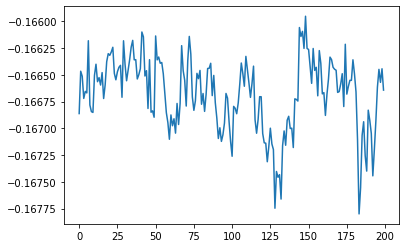

In [9]:
plt.plot(fff.reshape(1,1001).T[500:700])
#plt.plot([0 for _ in range(1001)])
plt.show()

In [10]:
np.std(fff.reshape(1,1001).T[500:700])

0.00034126229716543565

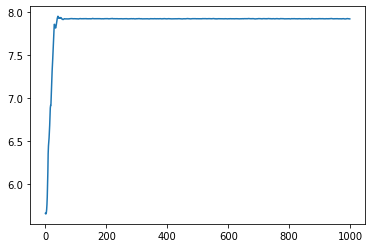

In [11]:
plt.plot(step_r)

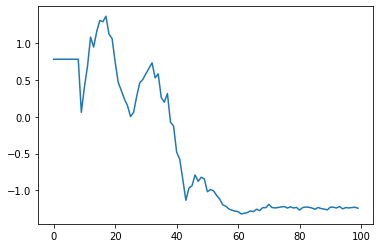

In [12]:
plt.plot(ddd.reshape(1,1001).T[0:100])
#plt.plot([-0.2 for _ in range(1001)])
plt.show()

In [13]:

if __name__ == '__main__':

    # train()
    test()





NameError: name 'test' is not defined